In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

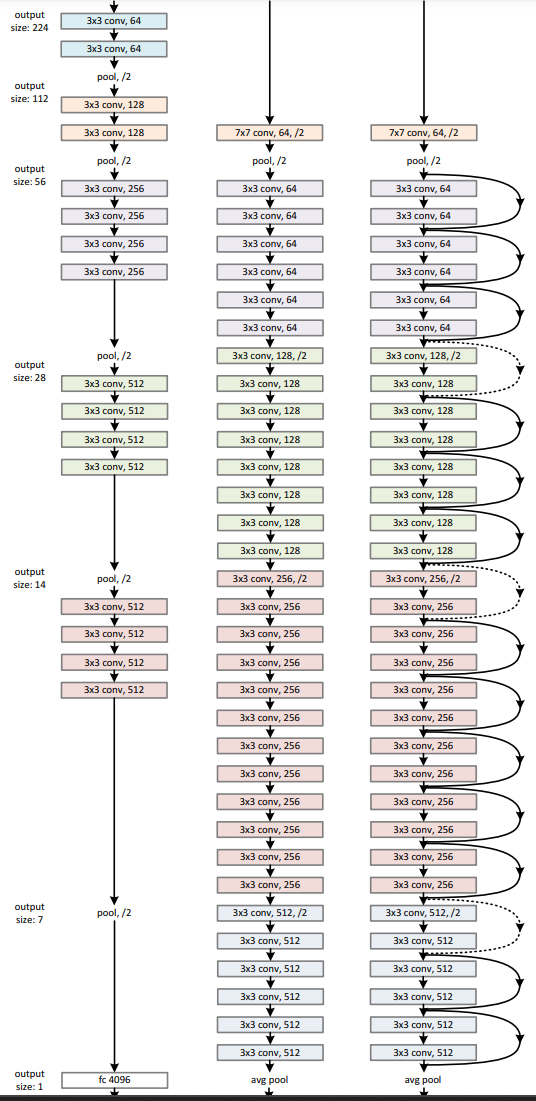

In [2]:
class BasicResidualBlock(nn.Module):
    def __init__(self,in_channels, out_channels, strides=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=strides, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample:
            identity = self.downsample(x)
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn(x)
        x += identity # Tensors have to have same dimension and channels
        x = self.relu(x)
        return x


In [3]:
class ResNet34(nn.Module):
    def __init__(self, num_classes=1000):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layers(64, 3, 1)
        self.layer2 = self._make_layers(128, 4, 2)
        self.layer3 = self._make_layers(256, 6, 2)
        self.layer4 = self._make_layers(512, 3, 2)

        self.gap = nn.AdaptiveAvgPool2d((1,1))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(512, num_classes)

    def _make_layers(self, out_channels, blocks, stride):
        layers = []
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        layers.append(BasicResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicResidualBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.gap(x)
        x = self.flatten(x)
        output = self.fc1(x)

        return output
        

In [4]:
device = "cpu"
learning_rate = 0.01
model = ResNet34().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [5]:
# !pip install torchsummary

In [6]:
from torchsummary import summary
summary(model, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
BasicResidualBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64

In [7]:
# Data preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [9]:
# Load CIFAR-10 dataset
from torch.utils.data import DataLoader
train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=False)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [10]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metrics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    return epoch_loss, accuracy


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    accuracy = 100.0 * correct / total
    return epoch_loss, accuracy


In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")